In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from brian2 import *
from functions import generate_connectivity_matrix

In [ ]:
# Params

simtime = 5000 * ms
dt = 0.1 * ms

# Cell
tau_M = 20 * ms
V_rest = -60 * mV
theta = -50 * mV
tau_ref = 5 * ms
g_L = 10 * nS

# Network
N_E = 8000
N_I = 2000

# Synapses
tau_E = 5 * ms
tau_I = 10 * ms
g_E_bar = 140 * psiemens
g_I_bar = 350 * psiemens
V_E = 0 * mV
V_I = -80 * mV
gamma = 0.13*ms

# STDP
alpha = 0.12
p0 = 5 * Hz
eta = 10**-3
tau_STDP = 20 * ms

# # Noise 
# sigma = 1 * mV

In [72]:
# Stimulus
I_b = 200*pA
Exc_array = np.ones([int(simtime/dt), N_E])*I_b
Inh_array = np.ones([int(simtime/dt), N_I])*I_b
I_b_exc = TimedArray(Exc_array, dt=dt)
I_b_inh = TimedArray(Inh_array, dt=dt)

In [73]:
start_scope()

In [74]:
# Neuron Model

eqs_exc = '''

dV/dt = ((V_rest - V) + (I_b_exc(t, i) + g_E*(V_E - V) + g_I*(V_I - V)) * 1/g_L) / tau_M : volt (unless refractory)

dg_E/dt = -g_E / tau_E : siemens
dg_I/dt = -g_I / tau_I : siemens

'''

eqs_inh = '''

dV/dt = ((V_rest - V) + (I_b_inh(t, i) + g_E*(V_E - V) + g_I*(V_I - V)) * 1/g_L) / tau_M : volt (unless refractory)

dg_E/dt = -g_E / tau_E : siemens
dg_I/dt = -g_I / tau_I : siemens

'''

In [75]:
# Neuron Groups
G_E = NeuronGroup(
                N_E,
                model=eqs_exc, 
                threshold='V>=theta', 
                reset='V=V_rest', 
                refractory=tau_ref,
                method='euler'
                )

G_I = NeuronGroup(
                N_I, 
                model=eqs_inh, 
                threshold='V>=theta', 
                reset='V=V_rest', 
                refractory=tau_ref,
                method='euler'
                )

In [76]:
Syn_EE = Synapses(G_E, G_E, on_pre='g_E += g_E_bar', delay=gamma)
Syn_IE = Synapses(G_E, G_I, on_pre='g_E += g_E_bar', delay=gamma)

Syn_EI = Synapses(
                G_I, G_E, 
                model='''
                w : 1
                dx/dt = -x / tau_STDP : 1 
                ''',
                on_pre='''
                g_I += w*g_I_bar
                x += 1
                w += eta * (x - alpha)
                ''',
                on_post='''
                w += eta * x 
                ''',
                method='euler',
                delay=gamma
                )

Syn_II = Synapses(G_I, G_I, on_pre='''g_I += g_I_bar''', delay=gamma)

all_synapses = [Syn_EE, Syn_IE, Syn_EI, Syn_II]

In [77]:
cm = generate_connectivity_matrix(N_E=N_E, N_I=N_I, p=0)

In [78]:
import time

In [79]:
connect_start_time = time.time()

connection_types = ['cm_EE',  'cm_IE', 'cm_EI', 'cm_II']
Syn = {connection_types[0]: Syn_EE,
       connection_types[1]: Syn_IE,
       connection_types[2]: Syn_EI,
       connection_types[3]: Syn_II}

for conn_type in connection_types:
    sources, targets = cm[conn_type].nonzero()
    Syn[conn_type].connect(i=sources, j=targets)
    
connect_end_time = time.time()

print('Time to connect all the synapses: {:.2f}'.format(connect_end_time - connect_start_time), ' sec.')

Time to connect all the synapses: 0.72  sec.


In [80]:
Poisson_E = PoissonInput(G_E, 'g_E', N=100, rate=5*Hz, weight=0.1*g_E_bar)
Poisson_I = PoissonInput(G_I, 'g_E', N=100, rate=5*Hz, weight=0.1*g_E_bar)

In [81]:
SpikeMonE = SpikeMonitor(G_E[:800], record=True)
SpikeMonI = SpikeMonitor(G_I[:200], record=True)
StateMonSyn_EI = StateMonitor(Syn_EI, ('w'), record=Syn_EI[:200])
monitors = [SpikeMonE, SpikeMonI, StateMonSyn_EI]

In [82]:
net = Network()
net.add(G_E, G_I, monitors, all_synapses, Poisson_I, Poisson_E)

In [83]:
G_E.V = V_rest
G_I.V = V_rest
Syn_EI.w = 0.1
Syn_EI.x = 0

In [84]:
net.run(simtime)

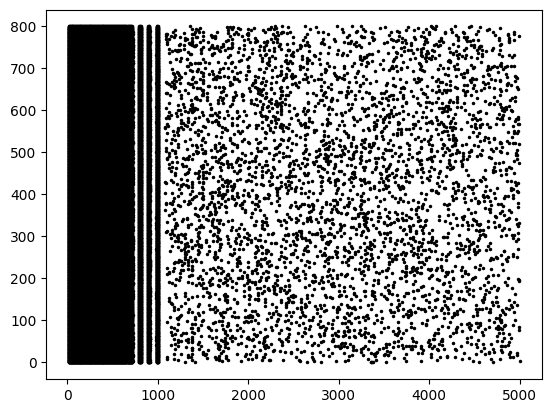

In [85]:
plt.plot(SpikeMonE.t/ms, SpikeMonE.i, '.k', ms=3)

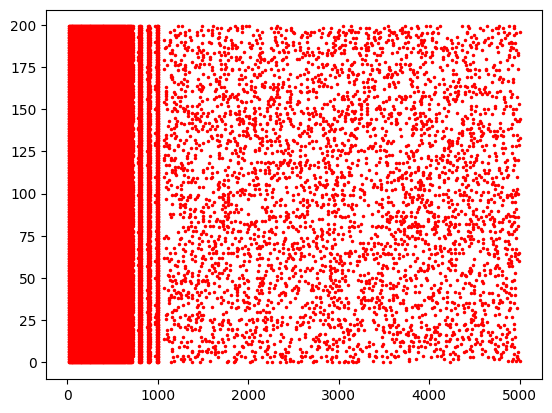

In [86]:
plt.plot(SpikeMonI.t/ms, SpikeMonI.i, '.r', ms=3)

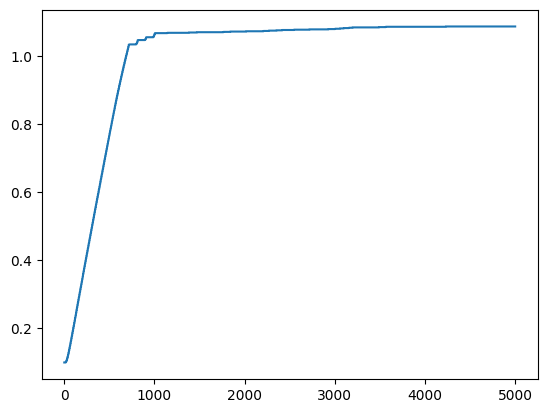

In [87]:
#plt.plot(StateMonSyn_EI.t/ms, np.mean(StateMonSyn_EI.x[:].T, 1))
plt.plot(StateMonSyn_EI.t/ms, np.mean(StateMonSyn_EI.w[:].T, 1))

In [88]:
from functions import get_spiking_correlation
from functions import get_isi_cv

In [89]:
spiketrains = SpikeMonE.spike_trains()
X = get_spiking_correlation(spiketrains=spiketrains, N1=int(N_E*0.1), N2=int(N_E*0.1))

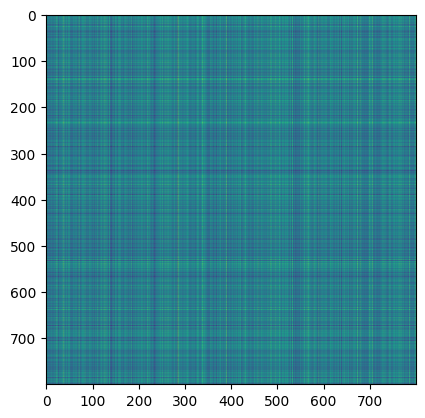

In [90]:
plt.imshow(X)

In [91]:
isi_cvs = get_isi_cv(sp=spiketrains)

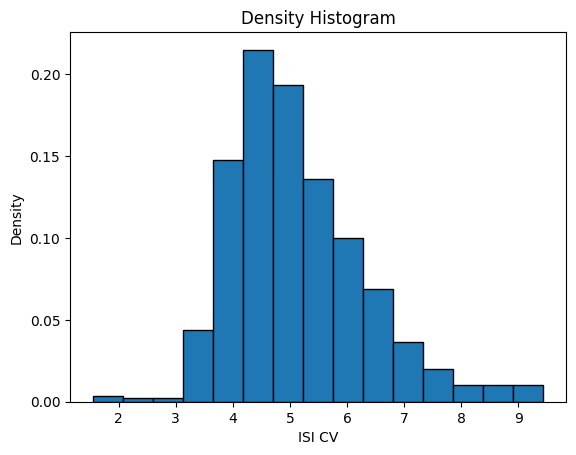

In [92]:
weights = np.ones_like(isi_cvs) / len(isi_cvs)
plt.hist(isi_cvs, bins=15, weights=weights, edgecolor='black')
plt.xlabel("ISI CV")
plt.ylabel("Density")
plt.title("Density Histogram")
plt.show()